https://www.kaggle.com/code/srinivasav22/text-preprocessing-and-advanced-functions

### Detection de sentiments / System de recommandation

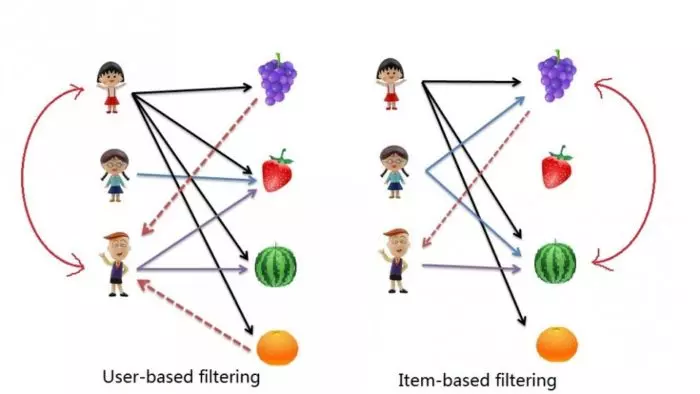

In [1]:
import os
import pandas as pd
import numpy as np
import dateparser
import re

In [2]:
import torch
from torch import cuda

In [3]:
import spacy
import fr_core_news_sm

In [4]:
from spacy.lang.fr.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf 
import matplotlib.pyplot as plt

In [5]:
torch.cuda

<module 'torch.cuda' from 'C:\\Users\\david\\anaconda3\\lib\\site-packages\\torch\\cuda\\__init__.py'>

In [8]:
torch.cuda.is_available() # uninstall conda 

False

In [ ]:
# conda uninstall torch
# conda uninstall torchvision
# conda uninstall torchaudio

# conda install pytorch torchvision cudatoolkit=11.7 -c pytorch -c conda-forge 

In [6]:
torch.cuda.is_available()

True

In [7]:
p = r'C:\Users\david\Downloads'
f = os.path.join(p, '', 'essai1249.json')
# df = pd.read_csv(f, lines=True, parse_dates=['date'], date_parser=dateparser.parse)
df = pd.read_json(f, lines=True)

### 1ere solution pour changer le format de date

In [8]:
print(df.shape)
df.head(5)

(376, 9)


,nom_auteur,prenom_auteur,titre,tags,note,date,appreciations,sexe_redacteur,commentaire
0,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",5.0,20 février 2020,5,Femme,Voici un livre extraordinaire sur l'absurdité ...
1,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,22 mars 2021,6,Femme,Kumaresan et Saroja sont amoureux fous. Malheu...
2,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,23 mai 2020,7,Femme,"Pour subvenir à ses besoins, Kumaresan quitte ..."
3,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,01 février 2020,9,Femme,"Malheureusement, les castes sont toujours d'ac..."
4,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,28 janvier 2020,17,Femme,"En ouvrant le bûcher, je suis totalement sorti..."


In [9]:
df.loc[8, 'note']

''

In [10]:
df['commentaire'][0]

'Voici un livre extraordinaire sur l\'absurdité des gens et des croyances. Comme ma lecture précédente, cette histoire a un petit goût de "Roméo et Juliette" : deux jeunes gens qui n\'auraient pas dû se rencontrer et encore moins s\'aimer, d\'après le système de castes très rigide indien. Mais l\'amour ne se contrôle pas. \nJ\'ai été profondément touchée par l\'histoire de nos deux jeunes personnages principaux, prêts à tout pour leurs sentiments, même à faire face aux courroux de la mère et des villageois aux mentalités plus qu\'arriérées : comment peut-on se comporter de la sorte, avoir des envies de meurtre contre deux jeunes amoureux, tout simplement parce qu\'ils ne font pas partie de la même caste ? \nLa jeune femme a beaucoup de courage de ne pas craquer face aux remarques acerbes et aux langues aussi acérées que des lames de couteaux ! C\'est terrible de voir ce que Saroja a sacrifié par amour : son confort, sa vie aisée, son existence très protégée.\nA travers cette histoire, 

In [11]:
# si pas assez de valeurs dans la colonnes df = df[df.columns[df.isna().sum() == 0]]
df = df.dropna().reset_index().drop(['index'], axis=1)
df.shape

(376, 9)

In [12]:
# attention ! truc == ''

### Test '' et NaN values

In [13]:
def test_null_values(df, print_=False, clean_nan=False):
    df_ = df.copy()
    for i, col in enumerate(df_.select_dtypes('object')):
        df_[col] = df_[col].apply(lambda x:np.nan if x=='' else x)
    if print_:
        print(df_.isna().sum()) 
    index_ = df_[pd.isnull(df_).any(1)].index
    if clean_nan:
        mask_nan = df_.index.isin(index_)
        df_ = df_[~mask_nan]
        df_ = df_.reset_index().drop(['index'], axis=1)
    return df_

In [14]:
df = test_null_values(df, print_=True, clean_nan=True)

nom_auteur         0
prenom_auteur      0
titre              0
tags               0
note              35
date               0
appreciations      0
sexe_redacteur     0
commentaire        0
dtype: int64


In [15]:
df.isnull().sum()

nom_auteur        0
prenom_auteur     0
titre             0
tags              0
note              0
date              0
appreciations     0
sexe_redacteur    0
commentaire       0
dtype: int64

### Formatage Datetime

In [16]:
dict_mapping = {'janvier' : 'January',
                'février' : 'February',
                'fevrier' : 'February',
                'mars' : 'March',
                'avril' : 'April',
                'mai' : 'May',
                'juin' : 'June',
                'juillet': 'July',
                'août' : 'August',
                'septembre' : 'September',
                'octobre' : 'October',
                'novembre' : 'November',
                'décembre' : 'December'}  

In [17]:
def format_date(df, col, dict_):
    date_list = df[col].tolist()
    new_date_list, index_problem = [], []
    for i, el in enumerate(date_list):
        for fr_word, en_word in dict_.items():
            if fr_word in el:
                el = el.strip().replace(fr_word, en_word)
        new_date_list.append(el)
    df['new_date'] = pd.Series(new_date_list)
    return df

In [18]:
df = format_date(df, 'date', dict_mapping)

In [19]:
df['new_date']

0      20 February 2020
1         22 March 2021
2           23 May 2020
3      01 February 2020
4       28 January 2020
             ...       
336       26 March 2019
337    07 February 2019
338    23 February 2019
339    26 February 2019
340       03 March 2019
Name: new_date, Length: 341, dtype: object

### Custom Stopwords

In [20]:
def tags_preprocessing(df):
    nlp = fr_core_news_sm.load()
    tags_list = ''.join(df['tags'].unique()).replace(',', ' ')
    lemm = [token.lemma_ for token in nlp(tags_list) if len(token)>3]
    return lemm

In [21]:
custom_stopwords = tags_preprocessing(df)
len(custom_stopwords)

47

In [22]:
def add_common_name_stopwords(df):
    nom_auteur = ' '.join(df['nom_auteur'].unique().tolist()).lower().split()   
    prenom_auteur = ' '.join(df['prenom_auteur'].unique().tolist()).lower().split()
    titre = ' '.join(df['titre'].unique().tolist()).lower().split()
    stop_words = nom_auteur + prenom_auteur + titre
    return stop_words

In [23]:
custom_stopwords += add_common_name_stopwords(df)
len(custom_stopwords)

54

In [24]:
df.head()

,nom_auteur,prenom_auteur,titre,tags,note,date,appreciations,sexe_redacteur,commentaire,new_date
0,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",5.0,20 février 2020,5,Femme,Voici un livre extraordinaire sur l'absurdité ...,20 February 2020
1,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,22 mars 2021,6,Femme,Kumaresan et Saroja sont amoureux fous. Malheu...,22 March 2021
2,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,23 mai 2020,7,Femme,"Pour subvenir à ses besoins, Kumaresan quitte ...",23 May 2020
3,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,01 février 2020,9,Femme,"Malheureusement, les castes sont toujours d'ac...",01 February 2020
4,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,28 janvier 2020,17,Femme,"En ouvrant le bûcher, je suis totalement sorti...",28 January 2020


### Preprocessing

In [25]:
def preprocessing(df):
    df["titre"] = df["titre"].apply(lambda x: x.strip())
    df["note"] = df["note"].apply(lambda x:np.nan if x=='' else float(x))
    df["Date"] = pd.to_datetime(df["new_date"]).dt.strftime('%Y-%m-%d')
    df["Date"] = pd.to_datetime(df["Date"])
    df["month"] =  df["Date"].dt.month 
    df["day_name"] = df["Date"].dt.day_name()
    df["day"] = df["Date"].dt.day
    df['sexe_redacteur'] = df['sexe_redacteur'].apply(lambda x: np.nan if x=='Inconnu' else x)
    df["homme"] = df["sexe_redacteur"].apply(lambda x: 1 if x=="Homme" else 0)
    df["femme"] = df["sexe_redacteur"].apply(lambda x: 1 if x=="Femme" else 0)
    return df

In [26]:
df = preprocessing(df)
df.head()

,nom_auteur,prenom_auteur,titre,tags,note,date,appreciations,sexe_redacteur,commentaire,new_date,Date,month,day_name,day,homme,femme
0,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",5.0,20 février 2020,5,Femme,Voici un livre extraordinaire sur l'absurdité ...,20 February 2020,2020-02-20,2,Thursday,20,0,1
1,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,22 mars 2021,6,Femme,Kumaresan et Saroja sont amoureux fous. Malheu...,22 March 2021,2021-03-22,3,Monday,22,0,1
2,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,23 mai 2020,7,Femme,"Pour subvenir à ses besoins, Kumaresan quitte ...",23 May 2020,2020-05-23,5,Saturday,23,0,1
3,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,01 février 2020,9,Femme,"Malheureusement, les castes sont toujours d'ac...",01 February 2020,2020-02-01,2,Saturday,1,0,1
4,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,28 janvier 2020,17,Femme,"En ouvrant le bûcher, je suis totalement sorti...",28 January 2020,2020-01-28,1,Tuesday,28,0,1


### Text preprocessing

In [27]:
# se renseigner sur nlp = fr_core_news_sm.load() ou fr_core_news_md.load() 

In [56]:
def text_preprocessing_with_lemma(df, col,stop_words=False):
    import string
    from spacy.lang.fr.stop_words import STOP_WORDS
    nlp = fr_core_news_sm.load()
    if stop_words:
        stopwords = [] + stop_words
    stopwords += list(STOP_WORDS) + ["neuf", "qu", "quelqu"]
    corpus = df["commentaire"].tolist()
    comms = []
    for el in corpus:
        out = el.replace("'", ' ')
        out = out.translate(str.maketrans(' ',' ',string.punctuation))
        out = out.replace(':', '').replace('\n', ' ').strip()
        out = [token.lemma_ for token in nlp(out) if (token.lemma_ not in stopwords) and (len(token) > 1) and (token.text not in stopwords) or (token.text=='x' or token.text=='y' or token.text=='i')]
        out = ' '.join(out)
        comms.append(out)
    df["commentaire_clean_lemma"] = pd.Series(comms)

    return df

In [57]:
def text_preprocessing_without_lemma(df, col,stop_words=False):
    import string
    from spacy.lang.fr.stop_words import STOP_WORDS
    nlp = fr_core_news_sm.load()
    if stop_words:
        stopwords = [] + stop_words
    stopwords += list(STOP_WORDS) + ["neuf", "qu", "quelqu", "livre", "lire", "auteur"]
    corpus = df["commentaire"].tolist()
    comms = []
    for el in corpus:
        out = el.replace("'", ' ')
        out = out.translate(str.maketrans(' ',' ',string.punctuation))
        out = out.replace(':', '').replace('\n', ' ').strip()
        comms.append(out)
    df["commentaire_clean_non_lemma"] = pd.Series(comms)

    return df

In [58]:
df = text_preprocessing_with_lemma(df, "commentaire", stop_words=custom_stopwords)
df = text_preprocessing_without_lemma(df, "commentaire", stop_words=custom_stopwords)

In [59]:
df["commentaire_clean_lemma"][0]

'extraordinaire absurdité croyance lecture précédent histoire petit goût roméo Juliette jeune devoir rencontrer aimer système caste rigide indien amour contrôle profondément toucher histoire jeune personnage principal prêt sentiment faire face courroux mère villageois mentalité arriéré peuton comporter sorte envie meurtre contre jeune amoureux simplement partie caste    jeune femme beaucoup courage craquer face remarque acerbe langue acérer lame couteau terrible voir Saroja sacrifier amour confort vie aisé existence protéger travers histoire découvrir mentalité indien coutume intransigeant campagne brosse portrait vivant donne voir ville emplir saveur grouillante vie écriture fluide agréable ravir découvrir connaître auparavant donner envi roman'

In [60]:
df["commentaire_clean_non_lemma"][0]

'Voici un livre extraordinaire sur l absurdité des gens et des croyances Comme ma lecture précédente cette histoire a un petit goût de Roméo et Juliette  deux jeunes gens qui n auraient pas dû se rencontrer et encore moins s aimer d après le système de castes très rigide indien Mais l amour ne se contrôle pas  J ai été profondément touchée par l histoire de nos deux jeunes personnages principaux prêts à tout pour leurs sentiments même à faire face aux courroux de la mère et des villageois aux mentalités plus qu arriérées  comment peuton se comporter de la sorte avoir des envies de meurtre contre deux jeunes amoureux tout simplement parce qu ils ne font pas partie de la même caste   La jeune femme a beaucoup de courage de ne pas craquer face aux remarques acerbes et aux langues aussi acérées que des lames de couteaux  C est terrible de voir ce que Saroja a sacrifié par amour  son confort sa vie aisée son existence très protégée A travers cette histoire l auteur nous fait découvrir certa

'Voici un livre extraordinaire sur l\'absurdité des gens et des croyances. Comme ma lecture précédente, cette histoire a un petit goût de "Roméo et Juliette" : deux jeunes gens qui n\'auraient pas dû se rencontrer et encore moins s\'aimer, d\'après le système de castes très rigide indien. Mais l\'amour ne se contrôle pas. \nJ\'ai été profondément touchée par l\'histoire de nos deux jeunes personnages principaux, prêts à tout pour leurs sentiments, même à faire face aux courroux de la mère et des villageois aux mentalités plus qu\'arriérées : comment peut-on se comporter de la sorte, avoir des envies de meurtre contre deux jeunes amoureux, tout simplement parce qu\'ils ne font pas partie de la même caste ? \nLa jeune femme a beaucoup de courage de ne pas craquer face aux remarques acerbes et aux langues aussi acérées que des lames de couteaux ! C\'est terrible de voir ce que Saroja a sacrifié par amour : son confort, sa vie aisée, son existence très protégée.\nA travers cette histoire, l\'auteur nous fait découvrir certaines mentalités indiennes et des coutumes intransigeantes, notamment à la campagne. Il nous brosse un portrait très vivant et donne tout de même à voir certaines villes emplies de saveurs et grouillantes de vie.\nL\'écriture est fluide et agréable et je suis ravie d\'avoir découvert cet auteur que je ne connaissais pas du tout auparavant.\nCela m\'a donné très envie de lire d\'autres romans de lui !'

### Alternative Text preprocessing

In [67]:
def text_preprocessing2(df, col):
    from spacy.lang.fr.stop_words import STOP_WORDS
    stopwords = list(STOP_WORDS)
    nlp = fr_core_news_sm.load()
    stopwords += ["neuf", "qu", "quelqu"]
    corpus = df["commentaire"].tolist()
    comms = []
    for el in corpus:
        s_chars = r"""-"/(),!.:+=[{()}]\^$?#*'%"""
        trans = str.maketrans(s_chars, ' '*len(s_chars))
        el = el.translate(trans)
        el = [token.lemma_ for token in nlp(el) if (token.lemma_ not in stopwords) and (len(token) > 1) and (token.text not in stopwords) or (token.text=='x' or token.text=='y' or token.text=='i')]
        el = ' '.join(el).replace('\n', ' ').replace('  ', ' ').replace('   ',' ')
        comms.append(el)
    df["commentaire_clean"] = pd.Series(comms)

    return df

In [68]:
df = text_preprocessing2(df, "commentaire")
df["commentaire_clean"][0]

'livre extraordinaire absurdité croyance lecture précédent histoire petit goût roméo Juliette jeune devoir rencontrer aimer système caste rigide indien amour contrôle  profondément toucher histoire jeune personnage principal prêt sentiment faire face courroux mère villageois mentalité arriéré  comporter sorte envie meurtre contre jeune amoureux simplement partie caste jeune femme beaucoup courage craquer face remarque acerbe langue acérer lame couteau  terrible voir Saroja sacrifier amour  confort vie aisé existence protéger travers histoire auteur découvrir mentalité indien coutume intransigeant campagne brosse portrait vivant donne voir ville emplir saveur grouillante vie écriture fluide agréable ravir découvrir auteur connaître auparavant donner envi lire roman'

### Ngrams

In [61]:
def ngrams_top(df, col, ngram_range=(1,1), n=None, stop_words=None):
    from sklearn.feature_extraction.text import CountVectorizer
    from spacy.lang.fr.stop_words import STOP_WORDS
    corpus = df[col]
    stopwords = []
    if stop_words:
        stopwords += stop_words
    stopwords += list(STOP_WORDS) + ["neuf", "qu", "quelqu", "livre", "lire", "auteur"]   # Stop-words
    vec = CountVectorizer(stop_words = stopwords, ngram_range=ngram_range).fit(corpus)    # CountVectorizer
    bag_of_words = vec.transform(corpus)                                                  # Sparse Matrix shape(376, 49060)
    sum_words = bag_of_words.sum(axis=0)                                                  # Vector        shape(  1, 49060)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]     # Counter-list   [('livre', 312),..
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)                    # Sorted Count [('houellebecq', 646),
    total_list=words_freq[:n]                                                             # Select n top rows
    df=pd.DataFrame(total_list,columns=["text","count"])                                  # Splitting in 'text', 'count' cols
    return df

In [62]:
ngrams_top_df = ngrams_top(df, "commentaire_clean_lemma", ngram_range=(1,2), n=15, stop_words=None)
ngrams_top_df

,text,count
0,houellebecq,586
1,roman,403
2,bien,327
3,vie,265
4,amour,221
5,sérotonine,219
6,monde,207
7,personnage,198
8,homme,181
9,michel,176


In [63]:
ngrams_top_df = ngrams_top(df, "commentaire_clean_lemma", ngram_range=(1,2), n=15, stop_words=custom_stopwords)
ngrams_top_df

,text,count
0,houellebecq,586
1,roman,403
2,bien,327
3,vie,265
4,amour,221
5,sérotonine,219
6,monde,207
7,personnage,198
8,homme,181
9,michel,176


In [64]:
ngrams_top2_df = ngrams_top(df, "commentaire_clean_lemma", ngram_range=(2,2), n=15, stop_words=custom_stopwords)
ngrams_top2_df

,text,count
0,michel houellebecq,139
1,ingénieur agronom,42
2,florentclaude labrouste,35
3,personnage principal,34
4,gilet jaune,32
5,carte territoire,29
6,ministère agriculture,28
7,bien sûr,23
8,roman houellebecq,22
9,46 an,20


### Vectorization

In [65]:
def vectorization(df, col):
    df2 = df.copy()
    mask = df["commentaire_clean_lemma"].apply(lambda x: type(x)==str)
    df = df.loc[mask,:]
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") 
    tokenizer.fit_on_texts(df["commentaire_clean_lemma"])
    df["commentaire_clean_lemma_encoded"] = tokenizer.texts_to_sequences(df["commentaire_clean_lemma"])
    reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(df["commentaire_clean_lemma_encoded"], padding="post")
    return df, reviews_pad

In [66]:
df, reviews_pad = vectorization(df, "commentaire_clean_lemma")
df['commentaire_clean_lemma_encoded']

AttributeError: keras not found

In [ ]:
reviews_pad

### TF-IDF

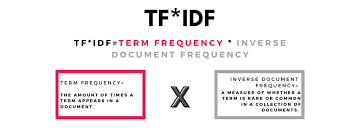

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 100
stop_words = custom_stopwords + list(STOP_WORDS) + ["neuf", "qu", "quelqu", "livre", "lire", "auteur"] 

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(df['commentaire_clean_lemma'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [67]:
print(tfidf.shape)
tfidf.todense()

(341, 100)


matrix([[0.        , 0.        , 0.        , ..., 0.15570001, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.16565236, 0.        , 0.09820284, ..., 0.0942498 , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.7494186 , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [68]:
print(tfidf_feature_names.shape)
tfidf_feature_names

(100,)


array(['agriculteur', 'agriculture', 'aime', 'aimer', 'ami', 'amoureux',
       'an', 'ancien', 'antidépresseur', 'autant', 'aymeric', 'beaucoup',
       'bien', 'bon', 'bonheur', 'bout', 'camille', 'captori', 'chose',
       'connaître', 'croire', 'dernier', 'devenir', 'devoir', 'donner',
       'drôle', 'décrire', 'dépressif', 'faire', 'falloir', 'femme',
       'fin', 'finir', 'florentclaude', 'fois', 'grand', 'histoire',
       'homme', 'humour', 'héros', 'ici', 'ingénieur', 'jamais', 'jeune',
       'kumaresan', 'lecteur', 'lecture', 'lien', 'littéraire', 'mal',
       'mettre', 'mieux', 'moment', 'monde', 'mot', 'narrateur', 'non',
       'oui', 'page', 'part', 'partie', 'passage', 'passer', 'perdre',
       'personnage', 'petit', 'plaisir', 'point', 'pourtant', 'pouvoir',
       'prendre', 'principal', 'propos', 'retrouve', 'retrouver', 'rien',
       'récit', 'savoir', 'scène', 'sens', 'sexe', 'sexuel', 'soumission',
       'style', 'sujet', 'temps', 'trop', 'trouve', 'trouver'

### Latent Dirichlet Analysis

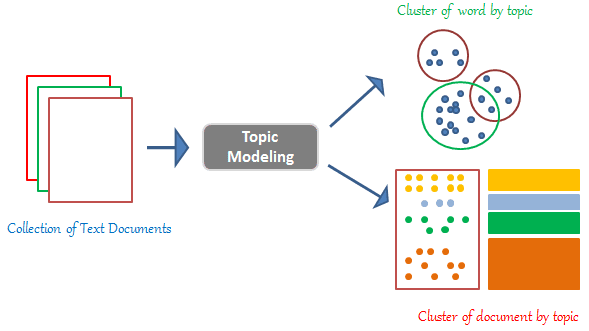

In [69]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=stop_words)
tf = tf_vectorizer.fit_transform(df['commentaire_clean_lemma'])
tf_feature_names = tf_vectorizer.get_feature_names_out()

### Non-Negative Matrix Factorization (NMF)

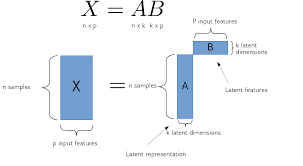

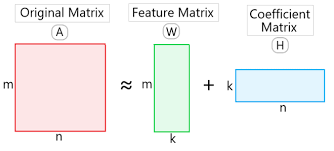

In [70]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

no_topics = 20

nmf = NMF(n_components=no_topics, random_state=1, alpha_W=.1, l1_ratio=.5, init='nndsvd').fit(tfidf) # alpha_H=.1

lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [71]:
lda.components_

array([[ 1.88996472,  0.64229712,  1.86040342, ...,  3.21670457,
         0.58175332,  1.49405192],
       [ 0.52619519,  0.44573978,  0.62903693, ...,  0.38621265,
         0.4157659 ,  1.5099578 ],
       [ 0.56575016,  0.45654178,  0.40322   , ...,  0.40142408,
         0.34491749,  0.62339605],
       ...,
       [ 0.47462051,  0.53569699,  0.48197776, ...,  0.46094544,
         1.598876  ,  1.30398186],
       [43.47178825, 25.32049869, 18.21830125, ...,  8.71997131,
        16.17497551, 12.38275777],
       [ 0.78854977,  0.6774    ,  0.53000398, ...,  1.19340337,
         0.83075355,  0.89033858]])

In [72]:
lda.components_.shape

(20, 100)

### Display & Evaluer les topics

In [73]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [74]:
no_top_words = 5

print("Topic NMF :")
display_topics(nmf, tfidf_feature_names, no_top_words)
print("\n\n\n")

print("Topic LDA :")
display_topics(lda, tf_feature_names, no_top_words)

Topic NMF :
Topic 0:
époque histoire décrire dépressif faire
Topic 1:
époque histoire décrire dépressif faire
Topic 2:
époque histoire décrire dépressif faire
Topic 3:
époque histoire décrire dépressif faire
Topic 4:
époque histoire décrire dépressif faire
Topic 5:
époque histoire décrire dépressif faire
Topic 6:
époque histoire décrire dépressif faire
Topic 7:
époque histoire décrire dépressif faire
Topic 8:
époque histoire décrire dépressif faire
Topic 9:
époque histoire décrire dépressif faire
Topic 10:
époque histoire décrire dépressif faire
Topic 11:
époque histoire décrire dépressif faire
Topic 12:
époque histoire décrire dépressif faire
Topic 13:
époque histoire décrire dépressif faire
Topic 14:
époque histoire décrire dépressif faire
Topic 15:
époque histoire décrire dépressif faire
Topic 16:
époque histoire décrire dépressif faire
Topic 17:
époque histoire décrire dépressif faire
Topic 18:
époque histoire décrire dépressif faire
Topic 19:
époque histoire décrire dépressif fair

### Preprocessing avec Text Blob

In [75]:
import nltk 
# nltk.download('omw-1.4')
import textblob
from textblob import Word, TextBlob

In [76]:
def preprocess_comments(df, col, custom_stopwords):
    preprocess_text = df[col].tolist()
    s= []
    for el in preprocess_text:
        preprocess_text = el.replace('[^\w\s]', '')
        preprocess_text = " ".join(word for word in preprocess_text.split() if word not in custom_stopwords)
        preprocess_text = " ".join(textblob.Word(word).lemmatize() for word in preprocess_text.split())
        s.append(preprocess_text)
    df["preprocess_comments"] = pd.Series(s)
    return df       

In [77]:
custom_stopwords = list(STOP_WORDS) + ["neuf", "qu", "quelqu", "livre", "lire", "auteur"] 

preprocess_comments(df, 'commentaire', custom_stopwords)[:3]

,nom_auteur,prenom_auteur,titre,tags,note,date,appreciations,sexe_redacteur,commentaire,new_date,...,day_name,day,homme,femme,commentaire_clean_lemma,commentaire_clean_non_lemma,commentaire_clean_lemma_encoded,preprocess_comments,polarité,subjectivité
0,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",5.0,20 février 2020,5,Femme,Voici un livre extraordinaire sur l'absurdité ...,20 February 2020,...,Thursday,20,0,1,extraordinaire absurdité croyance lecture préc...,Voici un livre extraordinaire sur l absurdité ...,"[3, 1, 919, 1, 28, 205, 17, 24, 380, 1, 1, 49,...",Voici extraordinaire l'absurdité croyances. Co...,-0.750000,0.875000
1,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,22 mars 2021,6,Femme,Kumaresan et Saroja sont amoureux fous. Malheu...,22 March 2021,...,Monday,22,0,1,Kumaresan saroja amoureux fou malheureusement ...,Kumaresan et Saroja sont amoureux fous Malheur...,"[98, 141, 105, 923, 566, 98, 52, 296, 1, 567, ...",Kumaresan Saroja amoureux fous. Malheureusemen...,0.000000,0.000000
2,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,23 mai 2020,7,Femme,"Pour subvenir à ses besoins, Kumaresan quitte ...",23 May 2020,...,Saturday,23,0,1,subvenir besoin Kumaresan quitte village natal...,Pour subvenir à ses besoins Kumaresan quitte s...,"[1, 215, 98, 354, 170, 1, 1, 1, 324, 142, 206,...","Pour subvenir besoins, Kumaresan quitte villag...",-0.355556,0.566667


### Sentiments avec TextBlob

In [78]:
df['polarité'] = df['commentaire_clean_lemma'].apply(lambda x: TextBlob(x).sentiment[0])
df['subjectivité'] = df['commentaire_clean_lemma'].apply(lambda x: TextBlob(x).sentiment[1])

In [79]:
df.head(2)

,nom_auteur,prenom_auteur,titre,tags,note,date,appreciations,sexe_redacteur,commentaire,new_date,...,day_name,day,homme,femme,commentaire_clean_lemma,commentaire_clean_non_lemma,commentaire_clean_lemma_encoded,preprocess_comments,polarité,subjectivité
0,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",5.0,20 février 2020,5,Femme,Voici un livre extraordinaire sur l'absurdité ...,20 February 2020,...,Thursday,20,0,1,extraordinaire absurdité croyance lecture préc...,Voici un livre extraordinaire sur l absurdité ...,"[3, 1, 919, 1, 28, 205, 17, 24, 380, 1, 1, 49,...",Voici extraordinaire l'absurdité croyances. Co...,-0.75,0.875
1,Perumal,Murugan,Le bûcher,"roman,roman d'amour,sentiments,traditions,litt...",4.0,22 mars 2021,6,Femme,Kumaresan et Saroja sont amoureux fous. Malheu...,22 March 2021,...,Monday,22,0,1,Kumaresan saroja amoureux fou malheureusement ...,Kumaresan et Saroja sont amoureux fous Malheur...,"[98, 141, 105, 923, 566, 98, 52, 296, 1, 567, ...",Kumaresan Saroja amoureux fous. Malheureusemen...,0.00,0.000


FuturWarning : problème d'aggregation (à verifier) : https://stackoverflow.com/questions/54890646/pandas-fails-to-aggregate-with-a-list-of-aggregation-functions

In [80]:
display(df[df['homme']==1][['homme', 'commentaire_clean_lemma', 'polarité', 'subjectivité']].groupby('homme').agg([np.mean, np.min, np.max, np.median]))
display(df[df['femme']==1][['femme', 'commentaire_clean_lemma', 'polarité', 'subjectivité']].groupby('femme').agg([np.mean, np.min, np.max, np.median]))

C:\Users\david\AppData\Local\Temp\ipykernel_27344\1063383667.py:1: FutureWarning: ['commentaire_clean_lemma'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  display(df[df['homme']==1][['homme', 'commentaire_clean_lemma', 'polarité', 'subjectivité']].groupby('homme').agg([np.mean, np.min, np.max, np.median]))


polarité                   subjectivité                    
           mean  amin amax median         mean amin amax    median
homme                                                             
1      0.105532 -0.55  1.0    0.0      0.41992  0.0  1.0  0.423958

C:\Users\david\AppData\Local\Temp\ipykernel_27344\1063383667.py:2: FutureWarning: ['commentaire_clean_lemma'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  display(df[df['femme']==1][['femme', 'commentaire_clean_lemma', 'polarité', 'subjectivité']].groupby('femme').agg([np.mean, np.min, np.max, np.median]))


polarité                  subjectivité                 
           mean amin amax median         mean amin amax median
femme                                                         
1      0.021685 -0.8  0.8    0.0     0.462559  0.0  1.0    0.5

In [81]:
homme = df[df['homme']==1][['Date', 'polarité']]
homme = homme.sort_values(by='Date', ascending=True)
homme['MA Polarité'] = homme['polarité'].rolling(10, min_periods=3).mean()

femme = df[df['femme']==1][['Date', 'polarité']]
femme = femme.sort_values(by='Date', ascending=True)
femme['MA Polarité'] = femme['polarité'].rolling(10, min_periods=3).mean()

In [82]:
homme.head(5)

,Date,polarité,MA Polarité
100,2019-01-06,0.032292,NaN
176,2019-01-06,0.033333,NaN
70,2019-01-07,0.070833,0.045486
46,2019-01-07,0.516667,0.163281
40,2019-01-07,-0.006250,0.129375


In [83]:
femme.head(5)

,Date,polarité,MA Polarité
26,2019-01-05,0.291667,NaN
241,2019-01-05,0.000000,NaN
195,2019-01-06,-0.322222,-0.010185
23,2019-01-06,-0.016667,-0.011806
22,2019-01-06,-0.008333,-0.011111


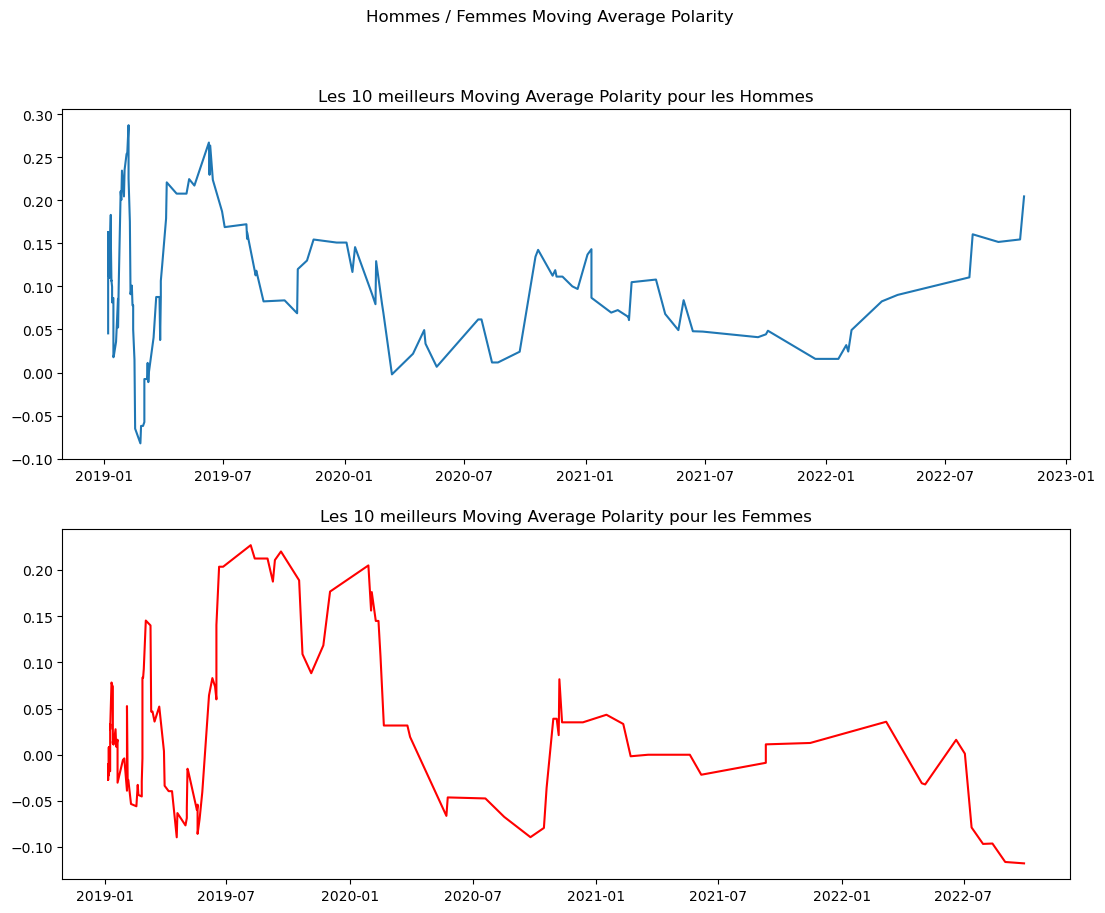

In [84]:
fig, axes = plt.subplots(2, 1, figsize=(13,10))

axes[0].plot(homme['Date'], homme['MA Polarité'])
axes[0].set_title("\n".join(['Les 10 meilleurs Moving Average Polarity pour les Hommes']))
axes[1].plot(femme['Date'], femme['MA Polarité'], color='red')
axes[1].set_title("\n".join(['Les 10 meilleurs Moving Average Polarity pour les Femmes']))

fig.suptitle('\n'.join(["Hommes / Femmes Moving Average Polarity"]), y=.98)
plt.show()

### TextBlob fr

In [65]:
from textblob import TextBlob, Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

In [63]:
# dans le terminal : python -m textblob.download_corpora
text = u"Quelle belle matinée"
blob = TextBlob(text)
blob.tags

[('Quelle', 'NNP'), ('belle', 'NN'), ('matinée', 'NN')]

In [66]:
blob.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [73]:
def blob_tags(text):
    blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    try:
        blob.tags
    except StopIteration:
        return

In [74]:
blob_tags(text)

RuntimeError: generator raised StopIteration

### Word2Vec

In [75]:
import gensim

In [76]:
gensim_commentaire = df['commentaire'].apply(gensim.utils.simple_preprocess)
gensim_commentaire_clean = df['commentaire_clean_lemma'].apply(gensim.utils.simple_preprocess)

In [77]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4,
)

In [78]:
model.build_vocab(gensim_commentaire, progress_per=1000)

In [79]:
model.epochs

5

In [80]:
df['commentaire_clean_non_lemma'][0]

'Voici un livre extraordinaire sur l absurdité des gens et des croyances Comme ma lecture précédente cette histoire a un petit goût de Roméo et Juliette  deux jeunes gens qui n auraient pas dû se rencontrer et encore moins s aimer d après le système de castes très rigide indien Mais l amour ne se contrôle pas  J ai été profondément touchée par l histoire de nos deux jeunes personnages principaux prêts à tout pour leurs sentiments même à faire face aux courroux de la mère et des villageois aux mentalités plus qu arriérées  comment peuton se comporter de la sorte avoir des envies de meurtre contre deux jeunes amoureux tout simplement parce qu ils ne font pas partie de la même caste   La jeune femme a beaucoup de courage de ne pas craquer face aux remarques acerbes et aux langues aussi acérées que des lames de couteaux  C est terrible de voir ce que Saroja a sacrifié par amour  son confort sa vie aisée son existence très protégée A travers cette histoire l auteur nous fait découvrir certa

In [81]:
review_gensim = df['commentaire_clean_non_lemma'].apply(gensim.utils.simple_preprocess)
review_gensim

0      [voici, un, livre, extraordinaire, sur, absurd...
1      [kumaresan, et, saroja, sont, amoureux, fous, ...
2      [pour, subvenir, ses, besoins, kumaresan, quit...
3      [malheureusement, les, castes, sont, toujours,...
4      [en, ouvrant, le, bûcher, je, suis, totalement...
                             ...                        
336    [du, bon, michel, mais, du, michel, en, roue, ...
337    [du, pesant, peutêtre, trop, mais, une, part, ...
338    [sérotonine, ou, le, récit, de, florentclaude,...
339    [dans, la, lignée, comme, habitude, ai, envie,...
340                                 [pas, son, meilleur]
Name: commentaire_clean_non_lemma, Length: 341, dtype: object

In [82]:
gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4
)

In [83]:
model.build_vocab(review_gensim, progress_per=1000)

In [84]:
model.epochs

5

In [85]:
model.corpus_count

341

In [86]:
model.train(review_gensim, total_examples=model.corpus_count, epochs=model.epochs)

(275829, 417890)

In [286]:
model.save('./save_gensim_model_word2vec.model')

In [87]:
model.wv.most_similar('vite')

[('en', 0.9993789196014404),
 ('par', 0.9993679523468018),
 ('pages', 0.9993612766265869),
 ('très', 0.9993542432785034),
 ('ces', 0.9993507266044617),
 ('plus', 0.9993471503257751),
 ('quand', 0.9993384480476379),
 ('trop', 0.9993360638618469),
 ('ici', 0.9993360042572021),
 ('cette', 0.9993312954902649)]

In [88]:
model.wv.similarity(w1='vite', w2='rapide')

0.99151075

### CamemBERT V1 : avec fast_bert

In [1]:
import torch
from fast_bert.data_cls import BertDataBunch
from fast_bert.learner_cls import BertLearner
from fast_bert.data_lm import BertLMDataBunch
from fast_bert.learner_lm import BertLMLearner
from fast_bert.metrics import fbeta, roc_auc
from fast_bert.prediction import BertClassificationPredictor
from pathlib import Path
import pandas as pd
import logging


logger = logging.getLogger()
device_cuda = torch.device("cuda")

on crée 4 sous répertoire :</br>
* **`/data`** : contient les données (sous forme de dataframes)
* **`/logs`** : 
* **`/models`** :
* **`/labels`** : contient le dataframe avec les labels (target)

In [2]:
DATA_PATH = Path('./data/')
LOG_PATH = Path('./logs/')
MODEL_PATH = Path('./model/')
LABEL_PATH = Path('./labels/')

Configuration en cours...

### CamemBERT

In [92]:
import torch
import seaborn
import pandas as pd
from sklearn import metrics
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, AdamW

Configuration en cours...

### Splitting dfs

In [47]:
n = len(df) // 7

In [48]:
for i in range(7):
    globals() [f"sample{i+1}"] = df.iloc[n*i:n*(i+1), :]
    globals() [f"sample{i+1}"].reset_index().drop(['index'],axis=1)

In [49]:
sample1.shape, sample2.shape, sample3.shape, sample4.shape, sample5.shape, sample6.shape, sample7.shape

((53, 18), (53, 18), (53, 18), (53, 18), (53, 18), (53, 18), (53, 18))

In [50]:
sample2

,nom_auteur,prenom_auteur,titre,tags,note,date,appreciations,sexe_redacteur,commentaire,new_date,Date,month,day_name,day,homme,femme,commentaire_clean,commentaire_clean_encoded
53,Michel,Houellebecq,Sérotonine,"roman,suicide,agriculture,amitié,introspection...",2.5,05 novembre 2019,25,Homme,Houellebecq continue à faire du Houellebecq ma...,05 November 2019,2019-11-05,11,Tuesday,5,1,0,Houellebecq continue faire Houellebecq roman g...,"[2, 521, 16, 2, 3, 1, 221, 549, 1, 879, 1, 209..."
54,Michel,Houellebecq,Sérotonine,"roman,suicide,agriculture,amitié,introspection...",0.5,08 janvier 2019,26,Inconnu,"Le Trump de la littérature française\n Alors, ...",08 January 2019,2019-01-08,1,Tuesday,8,0,0,trump littérature français dernier chef oeuvre...,"[1, 151, 91, 29, 1, 126, 1, 882, 676, 1, 1, 33..."
55,Michel,Houellebecq,Sérotonine,"roman,suicide,agriculture,amitié,introspection...",4.5,08 janvier 2019,27,Inconnu,Si je vous annonce que le protagoniste de ce n...,08 January 2019,2019-01-08,1,Tuesday,8,0,0,annoncer protagoniste Houellebecq homme désabu...,"[737, 732, 2, 15, 267, 38, 1, 210, 195, 361, 7..."
56,Michel,Houellebecq,Sérotonine,"roman,suicide,agriculture,amitié,introspection...",0.5,09 janvier 2019,27,Femme,J'ai lu à peu près la moitié avec obstination ...,09 January 2019,2019-01-09,1,Wednesday,9,0,1,lire moitié obstination refermer trop tôt aban...,"[13, 708, 1, 1, 35, 1, 1, 1, 584, 1, 215, 682,..."
57,Michel,Houellebecq,Sérotonine,"roman,suicide,agriculture,amitié,introspection...",3.0,20 mai 2020,27,Homme,Sérotonine. C'est le nom d'un neurotransmetteu...,20 May 2020,2020-05-20,5,Wednesday,20,1,0,Sérotonine nom neurotransmetteur voir vie rose...,"[10, 237, 1, 30, 7, 1, 1, 237, 29, 3, 14, 2, 1..."
58,Michel,Houellebecq,Sérotonine,"roman,suicide,agriculture,amitié,introspection...",5.0,20 janvier 2019,28,Femme,"J'aime bien Houellebecq. Bon, il est vrai que ...",20 January 2019,2019-01-20,1,Sunday,20,0,1,aime bien Houellebecq Bon vrai peubeaucoup mal...,"[72, 4, 2, 23, 99, 1, 65, 1, 359, 181, 223, 20..."
59,Michel,Houellebecq,Sérotonine,"roman,suicide,agriculture,amitié,introspection...",4.0,07 janvier 2019,29,Femme,J'aime Michel Houellebecq.\nJ'ai aimé ce livre...,07 January 2019,2019-01-07,1,Monday,7,0,1,aime Michel Houellebecq aimer livre aimer rir ...,"[72, 14, 2, 44, 5, 44, 578, 28, 578, 1, 47, 1,..."
60,Michel,Houellebecq,Sérotonine,"roman,suicide,agriculture,amitié,introspection...",3.5,08 janvier 2019,25,Homme,"Well back, Michel ! le retour de Houellebecq e...",08 January 2019,2019-01-08,1,Tuesday,8,1,0,Well back Michel Houellebecq considérer événem...,"[1, 1, 14, 2, 490, 811, 769, 163, 888, 109, 1,..."
61,Michel,Houellebecq,Sérotonine,"roman,suicide,agriculture,amitié,introspection...",3.0,17 janvier 2020,20,Homme,"Ce matin, j'ai reçu trois coups de fil dans l'...",17 January 2020,2020-01-17,1,Friday,17,1,0,matin recevoir coup fil intervalle peine heure...,"[844, 704, 129, 235, 1, 478, 488, 1, 1, 1, 156..."
62,Michel,Houellebecq,Sérotonine,"roman,suicide,agriculture,amitié,introspection...",3.5,26 mars 2020,20,Femme,"Du Houellebecq pur jus, du moins comme je me l...",26 March 2020,2020-03-26,3,Thursday,26,0,1,Houellebecq pur jus imagine lire livre y explo...,"[2, 624, 1, 778, 13, 5, 8, 1, 794, 398, 211, 1..."


In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [11]:
from transformers import pipeline

nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")

In [51]:
nlp(df['commentaire_clean'][0])

[{'entity_group': 'MISC',
  'score': 0.68247336,
  'word': 'Juliette',
  'start': 83,
  'end': 92},
 {'entity_group': 'MISC',
  'score': 0.8681167,
  'word': 'Saroja',
  'start': 476,
  'end': 483}]

In [ ]:
dic = {'aventure' : 33,
       'romans-policiers-et-polars' : 63883,
       'cinema' : 89,
       'roman' : 1,
       'biographie' : 31,
       'humour' : 15,
       'science-fiction' : 6,
       'thriller' : 11,
       'fantastique' : 7,
       'amour' : 77}

dic2 = {'litterature-francaise' : 3,
       'roman-noir' : 136,
       'essai' : 13,
       'nouvelles' : 23,
       'bande-dessinee' : 18,
       'tragedie' : 601,
       'autobiographie' : 45,
       'theatre' : 21,
       'jeunesse' : 14,
       'comics' : 142}

dic3 = {'journalisme' : 975,
       'guerre' : 91,
       'psychologie' : 65,
       'famille' : 290,
       'musique' : 44,
       'humour-noir' : 621,
       'reseaux-sociaux' : 26109,
       'enquetes' : 3988,
       'sentiments' : 1770,
       'thriller-psychologique' : 1073}

dic4 = {'entretiens' : 708,
       'amitie' : 373,
       'roman-fantastique' : 912,
       'serie' : 788,
       'classique' : 28,
       'comedie-romantique' : 3788,
       'manga' : 12,
       'litterature-americaine' : 9,
       'religion' : 26,
       'racisme' : 906}

dic5 = {'drogue' : 863,
       'geographie' : 187,
       'poesie' : 25,
       'dystopie' : 879,
       'western' : 533,
       'recit-de-voyage' : 448,
       'politique' : 54,
       'emotion' : 4100,
       'reportage' : 3488,
       'peur' : 430}

In [8]:
d =   {'aventure' : 33,
       'romans-policiers-et-polars' : 63883,
       'cinema' : 89,
       'roman' : 1,
       'biographie' : 31,
       'humour' : 15,
       'science-fiction' : 6,
       'thriller' : 11,
       'fantastique' : 7,
       'amour' : 77,
       'litterature-francaise' : 3,
       'roman-noir' : 136,
       'essai' : 13,
       'nouvelles' : 23,
       'bande-dessinee' : 18,
       'tragedie' : 601,
       'autobiographie' : 45,
       'theatre' : 21,
       'jeunesse' : 14,
       'comics' : 142,
       'journalisme' : 975,
       'guerre' : 91,
       'litterature-asiatique' : 1064,
       'fantasy' : 4,
       'psychologie' : 65,
       'famille' : 290,
       'musique' : 44,
       'humour-noir' : 621,
       'reseaux-sociaux' : 26109,
       'enquetes' : 3988,
       'sentiments' : 1770,
       'thriller-psychologique' : 1073,
       'entretiens' : 708,
       'amitie' : 373,
       'roman-fantastique' : 912,
       'serie' : 788,
       'classique' : 28,
       'comedie-romantique' : 3788,
       'manga' : 12,
       'litterature-americaine' : 9,
       'religion' : 26,
       'racisme' : 906,
       'drogue' : 863,
       'geographie' : 187,
       'poesie' : 25,
       'dystopie' : 879,
       'western' : 533,
       'recit-de-voyage' : 448,
       'politique' : 54,
       'emotion' : 4100,
       'reportage' : 3488,
       'peur' : 430}

In [9]:
sorted_dict = {key: value for key, value in sorted(d.items())}

In [10]:
sorted_dict

{'amitie': 373,
 'amour': 77,
 'autobiographie': 45,
 'aventure': 33,
 'bande-dessinee': 18,
 'biographie': 31,
 'cinema': 89,
 'classique': 28,
 'comedie-romantique': 3788,
 'comics': 142,
 'drogue': 863,
 'dystopie': 879,
 'emotion': 4100,
 'enquetes': 3988,
 'entretiens': 708,
 'essai': 13,
 'famille': 290,
 'fantastique': 7,
 'fantasy': 4,
 'geographie': 187,
 'guerre': 91,
 'humour': 15,
 'humour-noir': 621,
 'jeunesse': 14,
 'journalisme': 975,
 'litterature-americaine': 9,
 'litterature-asiatique': 1064,
 'litterature-francaise': 3,
 'manga': 12,
 'musique': 44,
 'nouvelles': 23,
 'peur': 430,
 'poesie': 25,
 'politique': 54,
 'psychologie': 65,
 'racisme': 906,
 'recit-de-voyage': 448,
 'religion': 26,
 'reportage': 3488,
 'reseaux-sociaux': 26109,
 'roman': 1,
 'roman-fantastique': 912,
 'roman-noir': 136,
 'romans-policiers-et-polars': 63883,
 'science-fiction': 6,
 'sentiments': 1770,
 'serie': 788,
 'theatre': 21,
 'thriller': 11,
 'thriller-psychologique': 1073,
 'tragedie